# Customer Indentification

## 1. Project Overview
- Basic project information
- Initial setup with common data science libraries


In [151]:
import polars as pl
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
# %matplotlib inline

In [ ]:
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(100)
pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_width_chars(200)

polars.config.Config

In [13]:
crm_eda_df = pl.read_csv("./data/crm_export.csv")
customers_eda_df = pl.read_csv("./data/customer_database.csv")
purchases_eda_df = pl.read_csv("./data/purchases.csv")

**Desired outcomes:**

- The output of this project should be a single dataset representing your customer data model—your best estimate of the entire customer base the startup currently has.
- Data will come from the three sources provided, and you will need to consolidate and deduplicate accordingly.
- You will need to decide on the structure of the data model based on the columns available in the datasets.
- This data model should be structured so that all the logic to define customers is already in place
    - answering the question “How many customers do we have?” should be done as simply as counting the rows.


## 2. Business Understanding
**Goal:** Define the problem and business objectives.
- What is the problem we’re solving?
- What are the business goals and success criteria?
- Who are the stakeholders?
- Business objectives
- Situation assessment
- Data mining goals
- Project plan

You have been hired by **Ebuy Emporium**, a new e-commerce startup. They have been up and running for a month and have had unexpected success. They are starting to have an active interest in their customer base.

**Questions:**
1. Who are their customers?
1. What do they buy?
1. What drives their purchasing behavior?
1. How many customers do they have?

However, before they do any serious analysis, they need to be able to count their customers, which happens to be more difficult than anticipated. 

## 3. Data Understanding
**Goal:** Explore and assess the data.
- What data is available
- Where does the come from?
- Data collection, description, and quality verification
- Initial data exploration (size, structure, missing values, distributions)
- Placeholder code for basic EDA

**One problem is there are multiple sources of customer data**:

1. The e-commerce platform’s customer database
    - where customer details are recorded when they sign up for an account online.
    - This is where most of the customer details should be found.

1. The in-house CRM (customer relationship management) system
    - where customer details are recorded when they make a purchase over the phone or are otherwise onboarded as customers (except because of purchasing online with a registered account).

1. The raw transaction data (sales/purchases)
    - we'll refer to as “purchases” or “sales,”
    - also contains purchases made “as a guest,” meaning customer records are not explicitly created at the time of purchase.


**Another problem is that the existing data sources may not be mutually exclusive—there might be overlaps across them all.**
- There is almost certainly some duplication either because:
    - the same customer had their details entered into multiple systems
    - or because they have made purchases both as a guest and with a registered account.
- Duplicate accounts may not contain exactly the same information; there may be typos or misspellings. 


### data dictionaries

#### “purchases” dataset
| **Column** | Definition |
| ------ | ---------- |
| **event_time** | The exact date and time the purchase occurred. |
| **product_id** | The unique identifier of the purchased product. |
| **category_id** | The unique identifier of the purchased product's specific category. |
| **category_code** | A broad category for the purchased product. In a hierarchy, category codes contain multiple category IDs, and one category_id should only be linked to one category_code. |
| **brand** | The purchased item's brand (if applicable). |
| **price** | The price the item was bought for (in USD). |
| **session_id** | A unique identifier for a purchase session. If multiple items are purchased in a transaction, each item will have a row in the table, and the rows will share a session_id. |
| **customer_id** | The unique identifier of the customer if they purchased using a registered account. For guest purchases, this value will be missing. |
| **guest_first_name** | The first name that was supplied if a purchase was made as a guest. For purchases made using registered accounts, this value will be missing. |
| **guest_surname** | The surname that was supplied if a purchase was made as a guest. For purchases made using registered accounts, this value will be missing. |
| **guest_postcode** | The postcode that was supplied if a purchase was made as a guest. For purchases made using registered accounts, this value will be missing. |

#### "CRM" and "Customers" datasets (share similar schema)
| **Column** | Definition |
| ------ | ---------- |
| **customer_id** | The unique identifier of the customer in this system. |
| **first_name** | The customer's first name. |
| **surname** | The customer's surname. |
| **postcode** | The customer's postal code. |
| **age** | The customer's age, in years. |
| **email** | The customer's email address. |
| **phone** | The customer's contact phone number. |
| **registration_date** | The date when the customer was registered in the system. |
| **last_purchase_date** | The date of the customer's most recent purchase. |
| **total_purchases** | The total number of purchases made by the customer. |
| **loyalty_tier** | The customer's loyalty program tier (e.g., Bronze, Silver, Gold). |

### CRM EDA
- 7825 rows
- 5 columns
- no nulls
- age range 0 - 100
    - avg is 40

In [22]:
pl.DataFrame(zip(crm_eda_df.columns, crm_eda_df.dtypes))

column_0,column_1
str,object
"""customer_id""",Int64
"""first_name""",String
"""surname""",String
"""postcode""",String
"""age""",Int64


In [ ]:
display(crm_eda_df.head())
display(crm_eda_df.describe())
display(crm_eda_df.shape)


customer_id,first_name,surname,postcode,age
i64,str,str,str,i64
29223,"""Holly""","""Rogers""","""LS475RT""",12
27826,"""Daniel""","""Owen""","""M902XX""",5
7432,"""Eleanor""","""Russell""","""HR904ZA""",34
2569,"""Paige""","""Roberts""","""DE732EP""",61
9195,"""Matilda""","""Young""","""LS670FU""",78


statistic,customer_id,first_name,surname,postcode,age
str,f64,str,str,str,f64
"""count""",7825.0,"""7825""","""7825""","""7825""",7825.0
"""null_count""",0.0,"""0""","""0""","""0""",0.0
"""mean""",17300.939936,null,null,null,40.009968
"""std""",9705.910369,null,null,null,24.893072
"""min""",5.0,"""Aachie""","""Accen""","""DE03US""",0.0
"""25%""",8797.0,null,null,null,21.0
"""50%""",17584.0,null,null,null,38.0
"""75%""",26096.0,null,null,null,56.0
"""max""",33280.0,"""Zuzanna""","""Yuung""","""SW990JE""",100.0


(7825, 5)

/var/folders/5r/tmlx34v94vbbqzx127znfb700000gn/T/ipykernel_55094/3324935962.py:15: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 1200x600 with 0 Axes>

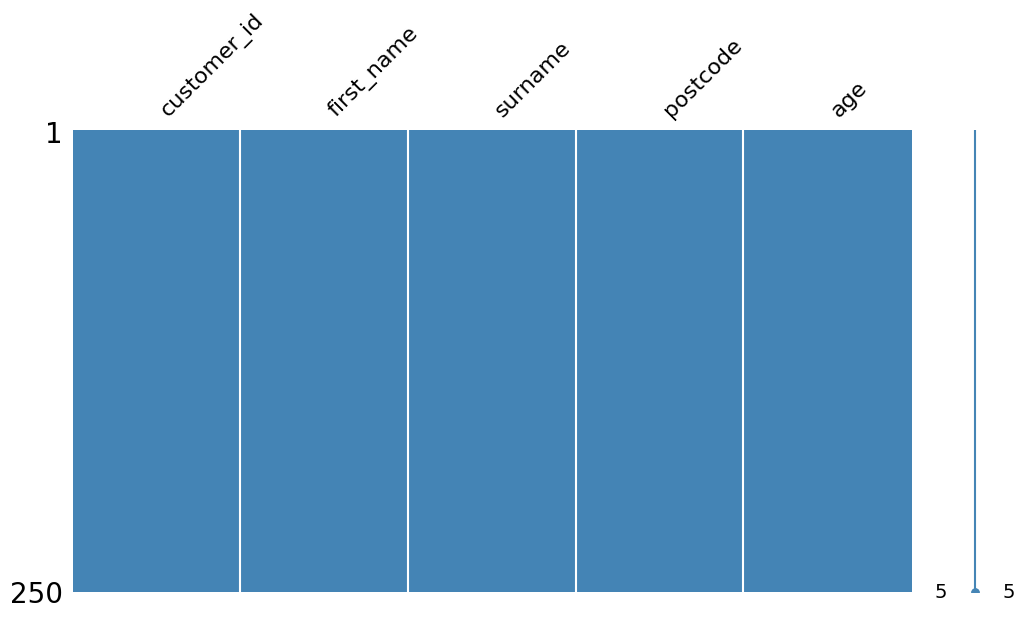

In [ ]:
# crm_eda_df.sample(250)

msno.matrix(crm_eda_df.to_pandas().sample(250))
# display(msno.bar(crm_eda_df.to_pandas().sample(100)))
# sns.heatmap(crm_eda_df.to_pandas().sample(100), cmap='viridis')
# plt.show()
# plt.show()
msno.heatmap(crm_eda_df.to_pandas().sample(250))
# msno.dendrogram(crm_eda_df.to_pandas().sample(250))
# msno.bar(crm_eda_df.to_pandas().sample(250))
# msno.matrix(crm_eda_df.to_pandas().sample(250))
# msno.matrix(crm_eda_df.to_pandas().sample(250))

# msno.heatmap(crm_eda_df.to_pandas())


In [105]:
crm_eda_df.select([
    pl.col(col_name).n_unique().alias(col_name)
    for col_name in crm_eda_df.columns
]).transpose(include_header=True, header_name="column", column_names=["unique_count"])\
    .sort("unique_count", descending=True)


column,unique_count
str,u32
"""customer_id""",7825
"""first_name""",686
"""postcode""",605
"""surname""",314
"""age""",101


In [125]:
fig = px.histogram(crm_eda_df, x="age", title="Age Distribution of CRMCustomers", nbins=40)
fig.show()


### Customers EDA
- 23,476 rows
- 5 columns
- no null values
- age ranges from 0 to 101
    - 0 could indicate null data
    - avg age of 40

In [21]:
pl.DataFrame(zip(customers_eda_df.columns, customers_eda_df.dtypes))

column_0,column_1
str,object
"""customer_id""",Int64
"""first_name""",String
"""surname""",String
"""postcode""",String
"""age""",Int64


In [15]:
display(customers_eda_df.head())
display(customers_eda_df.describe())
display(customers_eda_df.shape)


customer_id,first_name,surname,postcode,age
i64,str,str,str,i64
1641,"""Rhys""","""Richards""","""DE456EZ""",45
24796,"""Maisie""","""Young""","""SW433XX""",16
14358,"""Nathan""","""King""","""NW49TU""",58
15306,"""Jack""","""Moore""","""NW908RR""",26
24971,"""Alexander""","""Roberts""","""SW500HW""",85


statistic,customer_id,first_name,surname,postcode,age
str,f64,str,str,str,f64
"""count""",23476.0,"""23476""","""23476""","""23476""",23476.0
"""null_count""",0.0,"""0""","""0""","""0""",0.0
"""mean""",17195.245826,null,null,null,39.858281
"""std""",9734.124201,null,null,null,24.814917
"""min""",1.0,"""Aachie""","""Accen""","""DE03US""",0.0
"""25%""",8730.0,null,null,null,21.0
"""50%""",17371.0,null,null,null,38.0
"""75%""",25960.0,null,null,null,56.0
"""max""",33281.0,"""Zuzanna""","""Yovng""","""SW990JE""",101.0


(23476, 5)

In [106]:
customers_eda_df.select([
    pl.col(col_name).n_unique().alias(col_name)
    for col_name in customers_eda_df.columns
]).transpose(include_header=True, header_name="column", column_names=["unique_count"])\
    .sort("unique_count", descending=True)


column,unique_count
str,u32
"""customer_id""",23476
"""first_name""",1100
"""postcode""",605
"""surname""",569
"""age""",102


In [122]:
fig = px.histogram(customers_eda_df, x="age", title="Age Distribution of Customers", nbins=20)
fig.show()


### Purchases EDA
- 71,519 rows
- 11 columns
- several columns have null values
- guest names seem to be UPPER CASE


In [20]:
pl.DataFrame(zip(purchases_eda_df.columns, purchases_eda_df.dtypes))

column_0,column_1
str,object
"""event_time""",String
"""product_id""",Int64
"""category_id""",Int64
"""category_code""",String
"""brand""",String
"""price""",Float64
"""session_id""",String
"""customer_id""",Float64
"""guest_first_name""",String


In [23]:
display(purchases_eda_df.head(10))
display(purchases_eda_df.describe())
display(purchases_eda_df.shape)


event_time,product_id,category_id,category_code,brand,price,session_id,customer_id,guest_first_name,guest_surname,guest_postcode
str,i64,i64,str,str,f64,str,f64,str,str,str
"""2022-10-01 02:26:08+00:00""",32701106,2055156924466332447,null,"""shimano""",95.21,"""64c68405-7002-4ce0-9604-a4c2e1f7384b""",null,"""MICHAEL""","""MASON""","""RG497ZQ"""
"""2022-10-01 02:28:32+00:00""",9400066,2053013566067311601,null,"""jaguar""",164.2,"""3b7d6741-3c82-4c75-8015-6f54b52612e0""",7466.0,null,null,null
"""2022-10-01 02:31:01+00:00""",1004238,2053013555631882655,"""electronics.smartphone""","""apple""",1206.4,"""38c6d3f7-6c32-4fed-bca6-ef98e1746386""",null,"""COLE""","""WILKINSON""","""SW75TQ"""
"""2022-10-01 02:33:31+00:00""",11300059,2053013555531219353,"""electronics.telephone""","""texet""",17.48,"""3398c966-7846-4186-89be-323daad735b9""",null,"""MOHAMMED""","""RICHARDS""","""RG150RE"""
"""2022-10-01 02:40:18+00:00""",17300751,2053013553853497655,null,"""versace""",77.22,"""11e3a573-01b9-4794-b513-e7d8a4fcac83""",31266.0,null,null,null
"""2022-10-01 02:40:37+00:00""",1004856,2053013555631882655,"""electronics.smartphone""","""samsung""",130.76,"""d0132069-5827-4ebf-a1b3-b16496c9b396""",5.34142828e8,null,null,null
"""2022-10-01 02:43:40+00:00""",3601405,2053013563810775923,"""appliances.kitchen.washer""","""beko""",187.88,"""ea7c3a44-0908-4ef6-b175-bf4075e2665a""",1035.0,null,null,null
"""2022-10-01 02:44:11+00:00""",1004720,2053013555631882655,"""electronics.smartphone""","""huawei""",130.65,"""f8d45f96-6b2e-4886-8fb5-e59eab55cbe7""",null,"""KIAN""","""MILLS""","""SW332TF"""
"""2022-10-01 02:45:39+00:00""",41900000,2090971686529663114,"""appliances.environment.vacuum""",null,23.6,"""87f507c9-8679-4b25-87f0-dc90e36b7b6d""",6985.0,null,null,null


statistic,event_time,product_id,category_id,category_code,brand,price,session_id,customer_id,guest_first_name,guest_surname,guest_postcode
str,str,f64,f64,str,str,f64,str,f64,str,str,str
"""count""","""71519""",71519.0,71519.0,"""54780""","""65812""",71519.0,"""71519""",53071.0,"""18448""","""18448""","""18448"""
"""null_count""","""0""",0.0,0.0,"""16739""","""5707""",0.0,"""0""",18448.0,"""53071""","""53071""","""53071"""
"""mean""",null,6.4738e6,2.0551e18,null,null,303.220584,null,2.7289e7,null,null,null
"""std""",null,8.7907e6,1.3835e16,null,null,339.22116,null,1.1791e8,null,null,null
"""min""","""2022-10-01 02:26:08+00:00""",1.001588e6,2.0530e18,"""accessories.bag""","""a-mega""",0.81,"""00007b3f-ec7a-4d2e-ac44-64dfec829806""",1.0,"""AALIYAH""","""ADAMS""","""DE03US"""
"""25%""",null,1.004856e6,2.0530e18,null,null,87.0,null,9403.0,null,null,null
"""50%""",null,1.801805e6,2.0530e18,null,null,179.85,null,18847.0,null,null,null
"""75%""",null,8.700289e6,2.0530e18,null,null,370.12,null,27618.0,null,null,null
"""max""","""2022-10-31 23:55:13+00:00""",6.0500001e7,2.1724e18,"""stationery.cartrige""","""zte""",2570.18,"""fffe2010-d084-4e54-b865-ed77a28633ea""",5.66239774e8,"""ZUZANNA""","""YOUNG""","""SW990JE"""


(71519, 11)

In [ ]:
# Display the number of unique values in each column
purchases_eda_df.select([
    pl.col(col_name).n_unique().alias(col_name)
    for col_name in purchases_eda_df.columns
]).transpose(include_header=True, header_name="column", column_names=["unique_count"])\
    .sort("unique_count", descending=True)

column,unique_count
str,u32
"""event_time""",70143
"""session_id""",60658
"""customer_id""",24962
"""product_id""",12294
"""price""",10694
"""brand""",1095
"""guest_postcode""",606
"""guest_first_name""",498
"""category_id""",476


In [184]:
purchases_eda_pdf = purchases_eda_df.to_pandas()

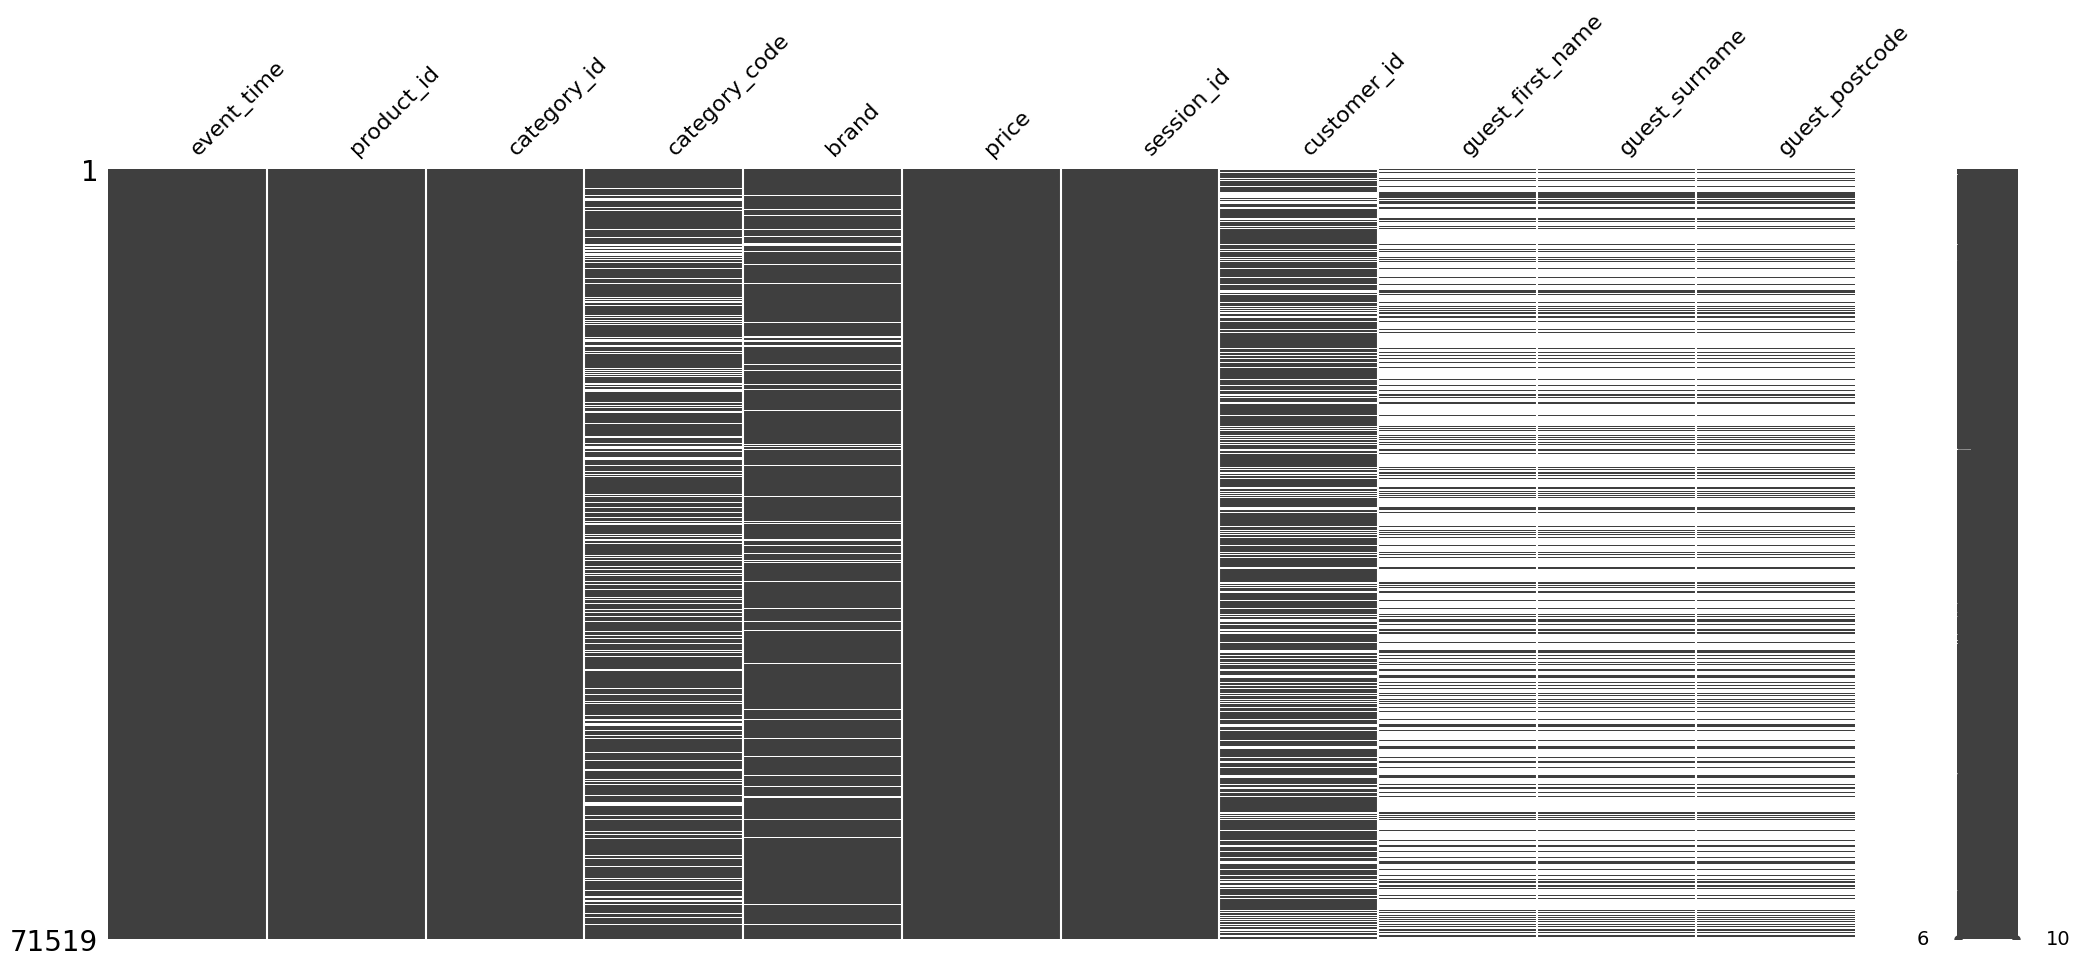

In [ ]:
"""
1. Complete Columns (solid black):
- `event_time`, `product_id`, `category_id`, `price`, and `session_id` are completely filled
- These form the core transaction data and show consistent data collection

2. Partially Missing Columns with Patterns:
- `category_code` and `brand` show sporadic missing values (white gaps)
- The missing values appear somewhat randomly distributed
- This suggests these fields aren't systematically missing but might be related to specific products or data entry issues

3. Clear Complementary Pattern:
- There's a complementary relationship between `customer_id` and the guest fields (`guest_first_name`, `guest_surname`, `guest_postcode`)
- When `customer_id` is present (black), the guest fields are missing (white)
- When guest information is present, `customer_id` is missing
- This pattern is very consistent and shows a clean separation between registered and guest users

4. Guest Information Pattern:
- The three guest fields (`guest_first_name`, `guest_surname`, `guest_postcode`) show identical missing patterns
- This confirms they're always collected together
- When one guest field is present, all are present. When one is missing, all are missing

Recommendations:
1. This is a well-structured dataset with clear separation between guest and registered user data
2. The consistent pattern in guest/customer fields suggests good data validation at entry
3. Could use this understanding for creating separate analysis for guest vs. registered users

"""
msno.matrix(purchases_eda_pdf)
_ = plt.show()

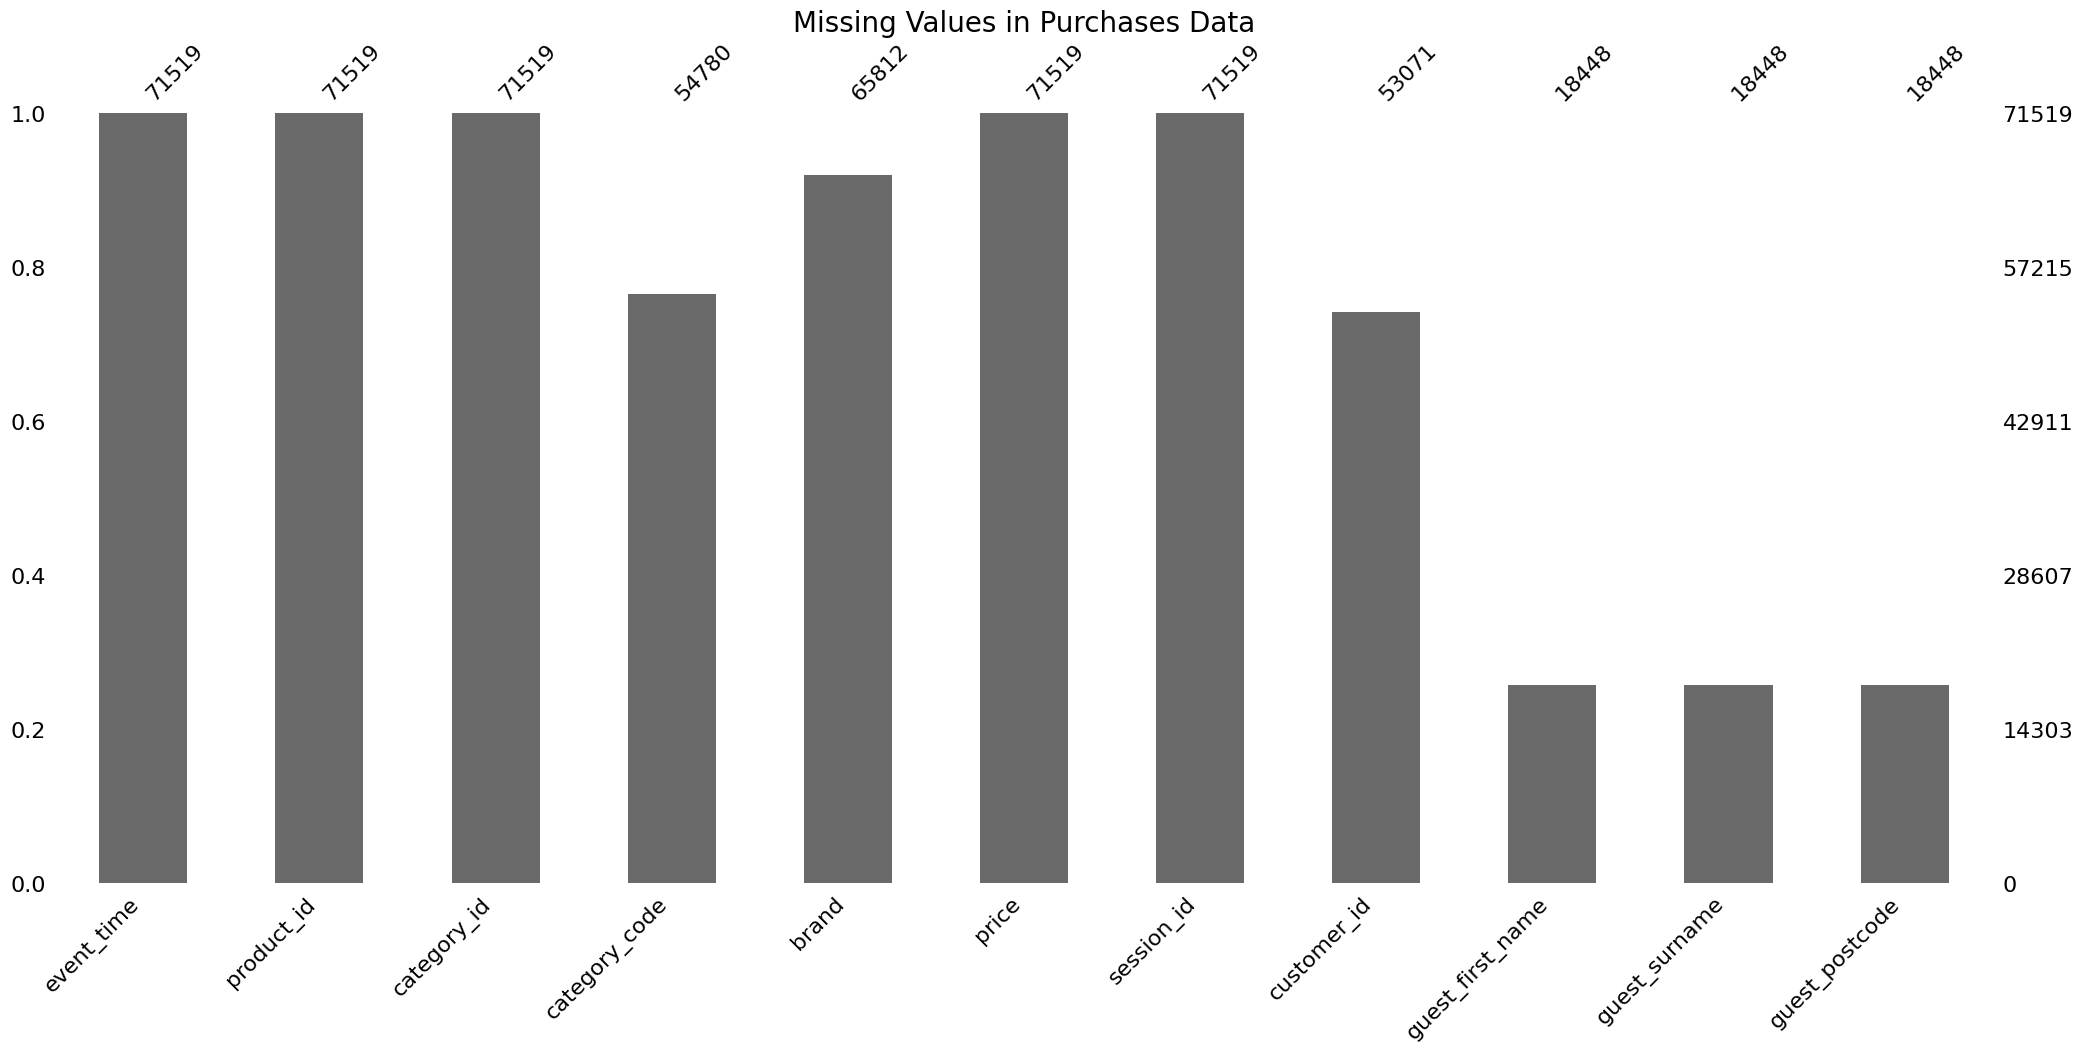

In [201]:
"""
1. Fully/Nearly Complete Fields (100%):
- `event_time`, `product_id`, `category_id`, `price`, and `session_id` all have around 71,519 values
- These are core transaction/event data fields that appear to be consistently captured

2. Highly Complete Fields (75-90%):
- `category_code` (~54,780 values) and `brand` (~65,812 values)
- These product-related fields have good coverage but some missing values
- Could indicate either data quality issues or legitimate cases where these attributes don't apply

3. Moderately Complete Fields:
- `customer_id` (~53,071 values) has about 74% completion
- This suggests roughly 3/4 of transactions are from registered customers

4. Low Completion Fields (~25%):
- `guest_first_name`, `guest_surname`, and `guest_postcode` all have around 18,448 values
- This aligns with the previous nullity correlation heatmap
- These guest fields represent roughly 26% of transactions
- The equal numbers confirm these fields are filled together for guest purchases

Business Insights:
1. About 74% of transactions are from registered customers, 26% from guests
2. Product categorization could be improved (some missing category codes)
3. Brand information could be more complete
4. Core transaction data is very reliable (no missing values)

Future Recommendations:
1. Investigate why some products lack category codes and brand information
2. Enforce data validation at entry for product metadata (category_code, brand)

"""
# Create a bar chart showing missing values
fig = msno.bar(purchases_eda_pdf)
plt.title('Missing Values in Purchases Data', fontsize=20)
_ = plt.show()

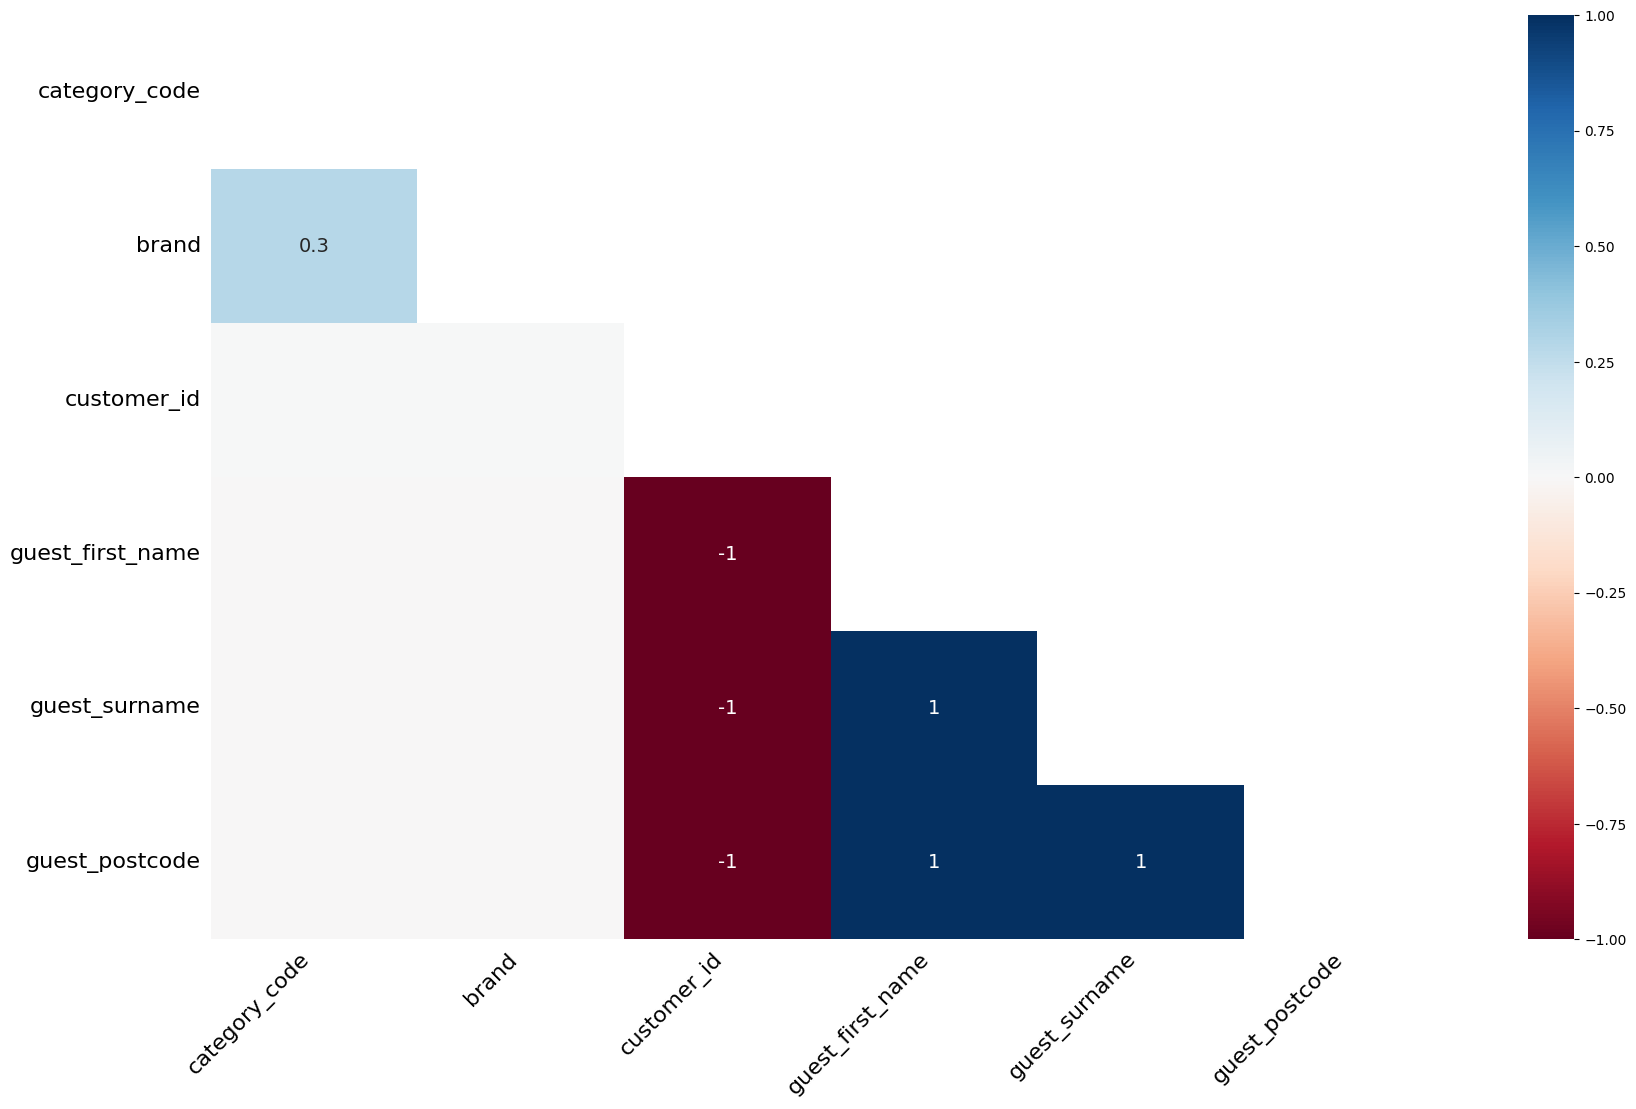

In [191]:
"""
Strong Correlations:
- There's a perfect positive correlation (1.0) between guest_surname and guest_first_name
- guest_postcode is also perfectly correlated (1.0) with both name fields
- This suggests that when one of these fields is missing, the others are also missing

Negative Correlations:
- customer_id has a perfect negative correlation (-1.0) with the guest fields (first_name, surname, and postcode)
- This indicates a mutually exclusive relationship: when customer_id is present, the guest fields are missing, and vice versa
- This makes logical sense if your system either tracks customers by ID OR as guest information

Weak/Moderate Correlations:
- brand shows a weak positive correlation (0.3) with category_code
- This suggests a slight tendency for these fields to be missing together, but the relationship isn't strong

Business Implications:
- The data appears to have two distinct types of records:
    - registered customers (with customer_id)
    - guest customers (with name/postcode)
"""
msno.heatmap(purchases_eda_pdf)
_ = plt.show()


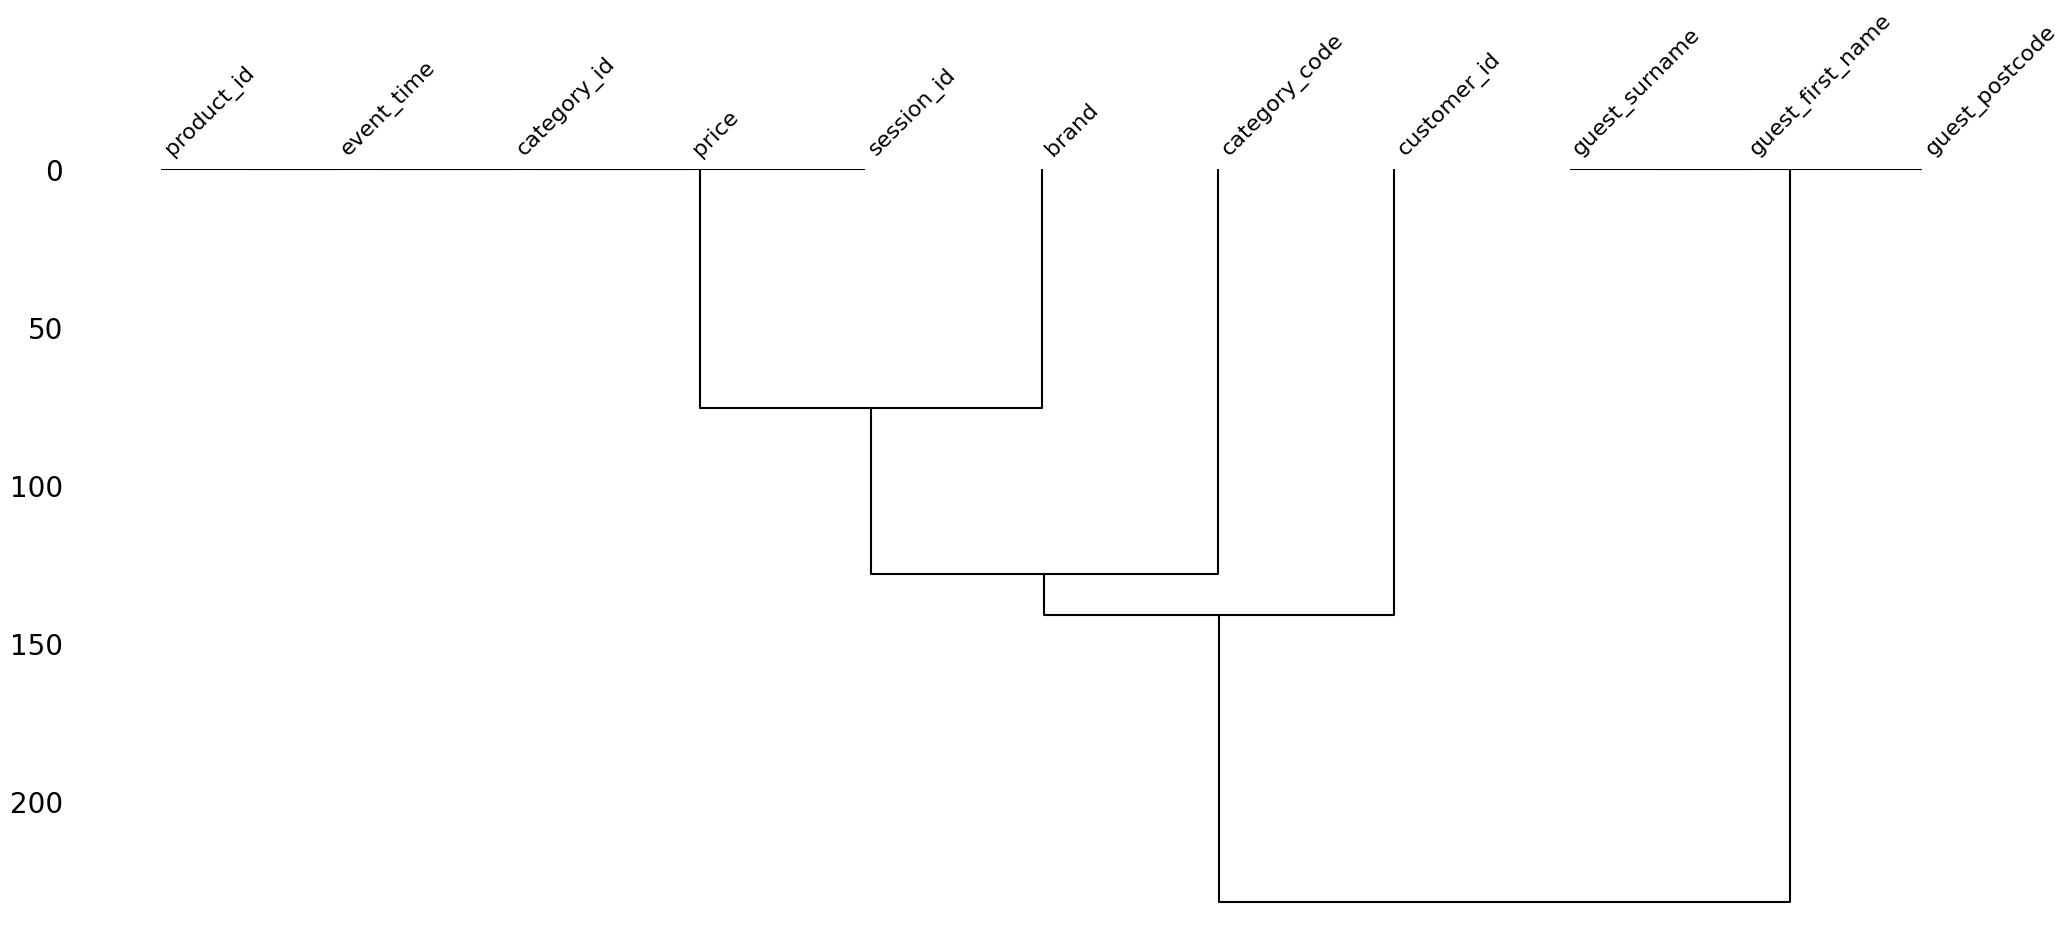

In [192]:
msno.dendrogram(purchases_eda_pdf)
_ = plt.show()

In [104]:
k = 10
category_data = purchases_eda_df\
    .with_columns(pl.col("category_id").cast(pl.Utf8).alias("category_id"))\
    .group_by("category_id")\
    .agg(pl.len().alias("count"))\
    .sort("count", descending=True)\
    .top_k(k, by="count")

category_code_data = purchases_eda_df\
    .with_columns(pl.col("category_code").cast(pl.Utf8).alias("category_code"))\
    .group_by("category_code")\
    .agg(pl.len().alias("count"))\
    .sort("count", descending=True)\
    .top_k(k, by="count")

product_data = purchases_eda_df\
    .with_columns(pl.col("product_id").cast(pl.Utf8).alias("product_id"))\
    .group_by("product_id")\
    .agg(pl.len().alias("count"))\
    .sort("count", descending=True)\
    .top_k(k, by="count")

brand_data = purchases_eda_df\
    .with_columns(pl.col("brand").cast(pl.Utf8).alias("brand"))\
    .group_by("brand")\
    .agg(pl.len().alias("count"))\
    .sort("count", descending=True)\
    .top_k(k, by="count")

# Create subplot layout
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Top Categories", "Top Category Codes", "Top Products", "Top Brands"),
                    shared_yaxes=False)

# Add bar chart to first subplot
fig.add_trace(
    go.Bar(x=category_data["category_id"],
           y=category_data["count"],
           marker=dict(color=category_data["count"],
                      coloraxis="coloraxis")),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=category_code_data["category_code"],
           y=category_code_data["count"],
           marker=dict(color=category_code_data["count"],
                      coloraxis="coloraxis")),
    row=1, col=2
)

# Add column chart to second subplot
fig.add_trace(
    go.Bar(x=product_data["product_id"],
           y=product_data["count"],
           marker=dict(color=product_data["count"],
                      coloraxis="coloraxis")),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=brand_data["brand"],
           y=brand_data["count"],
           marker=dict(color=brand_data["count"],
                      coloraxis="coloraxis")),
    row=2, col=2)


# Update layout
fig.update_layout(
    title=f"Top {k} Categories",
    coloraxis=dict(colorscale='Bluered_r'),
    showlegend=False,
    height=700,  # Increased height for more vertical space
    margin=dict(t=100, b=100),  # Add top and bottom margins
    grid=dict(rows=2, columns=2, pattern='independent', roworder='top to bottom'),
    grid_ygap=0.3  # Increase vertical gap between subplots (30% of the height)
)

fig.show()

## 4. Data Preparation
**Goal:** Clean, transform, and structure the data for modeling.
- Handle missing values and duplicates
- Engineer new features if necessary
- Normalize, encode, or scale data as needed
- Data cleaning
- Feature engineering
- Data transformation

**Here are some key questions to consider:**

- What are the possible ways in which customers can be represented across these datasets? It may be helpful to list all scenarios (customers in CRM, customers who made a purchase, guest checkouts, etc.) to hone in on exactly what you will need to code.

- When you consider duplicates, how will linked accounts (i.e., a main account versus linked accounts) be represented?

- When deduplicating records, what fields do you want to use for deduplication? Are two people with the same name living at the same postcode necessarily the same person? How much do two customers’ details need to differ before we consider them different people?

## 5. Modeling
**Goal:** Select and apply appropriate models.
- What models will be tested?
- Define the target variable and evaluation metrics.
- Train, tune, and compare models.
- Model selection
- Model building
- Model assessment

First, we need to understand the question: “Who are our customers?” which would normally require some pushback for clarification. In this instance, whatever the actual analytical question about customers is, the data modeling step is fundamental to answering it. We must first consolidate the customer data from the three data sources.

We could think about what additional data to augment it with to better fit the needs of the analytical questions. We know we want to end up with one row per customer, but we don’t yet know if a summary of the customer’s purchase history would be a useful addition. In this case, we don’t want to spend time preemptively adding information to our data model because we think someone might ask for it down the line.

Our end product is quite well defined, but, specifically, starting from the end here means having an idea of the structure of the final data model, the existence of which will allow us to count customers to produce our minimum viable answer. We know that one of its most important properties should be that it contains one row per customer. That’s the level of granularity we’re aiming for. Any purchase data we augment it with would, therefore, need to be aggregated to the customer level; we couldn’t include individual products purchased by a customer but could include their total spending, the date they first signed up, the number of unique purchases they made, and so forth.

Another aspect of looking ahead at our end result is to identify the schema of our final data model. What columns are common across our datasets? Are there columns we will have to drop before we combine the data sources, or are they important enough that we will accept some missing data in our final solution? In data modeling, these are all important aspects to think about up front, so we can keep them in mind while in the weeds of coding our solution, and we don’t spend time manipulating data that we cannot use in the final data model.


## 6. Evaluation
**Goal:** Assess model performance and business impact.
- Review model accuracy, precision, recall, etc.
- Compare results to business objectives.
- Identify any risks or limitations.
- Results evaluation
- Process review
- Next steps determination

## 7. Deployment
**Goal:** Implement the model in production.
- Deployment plan: How will the model be deployed (batch, API, etc.)?
- Monitoring and maintenance: What ongoing checks and updates are needed?
- Final project report: Document outcomes, lessons learned, and future improvements.